In [1]:
import numpy as np
import pandas as pd
from scipy import sparse
import matplotlib.pyplot as plt
from sklearn.metrics import balanced_accuracy_score as bas


import gc
gc.enable()

In [9]:
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.models import Sequential, Input
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping

from keras.optimizers import RMSprop, Adam
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, GRU
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

Using TensorFlow backend.


In [2]:
# data = pd.read_csv('../data-simplified-1-reduced-wordbal-800.csv')
data = pd.read_csv('../data-reduced-800-v3-shuffled.csv', index_col = 0)

/store/tveiga/miniconda3/envs/py/lib/python3.7/site-packages/numpy/lib/arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
test = pd.read_csv('../test.csv')

In [4]:
catcode = pd.read_csv('../data-simplified-1-catcode.csv', header = None, names = ['category'])['category']

In [5]:
catcode.to_dict()

{0: '3D_GLASSES',
 1: '3D_PENS',
 2: '3D_PRINTERS',
 3: '3D_PRINTER_FILAMENTS',
 4: 'ABDOMINAL_TONING_BELTS',
 5: 'ABS_SENSORS',
 6: 'AB_ROLLER_WHEELS',
 7: 'ACCORDIONS',
 8: 'ACOUSTIC_GUITARS',
 9: 'ACOUSTIC_PANELS',
 10: 'ACTION_CAMERA_MOUNTS',
 11: 'ACTION_FIGURES',
 12: 'ADHESIVE_TAPES',
 13: 'AEROBIC_CRUNCH_MACHINES',
 14: 'AFTERSHAVES',
 15: 'AGOGOS',
 16: 'AIRBAGS',
 17: 'AIRBAG_MODULES',
 18: 'AIRBRUSHES',
 19: 'AIRGUN_PELLETS',
 20: 'AIRSOFT_GUNS',
 21: 'AIR_COMPRESSORS',
 22: 'AIR_CONDITIONERS',
 23: 'AIR_CONDITIONER_REMOTE_CONTROLS',
 24: 'AIR_FRESHENERS',
 25: 'AIR_MATTRESSES',
 26: 'ALARMS_AND_SENSORS',
 27: 'ALARM_CLOCKS',
 28: 'ALL_IN_ONE',
 29: 'ALTERNATORS',
 30: 'ALTERNATOR_PULLEYS',
 31: 'AM_FM_RADIOS',
 32: 'ANALOG_CAMERAS',
 33: 'ANGLE_CLAMPS',
 34: 'ANIMAL_AND_BALL_HOPPERS',
 35: 'ANIMAL_CLIPPERS',
 36: 'ANTIQUE_CHAIRS',
 37: 'ANTIQUE_TAPE_RECORDERS',
 38: 'ANTIQUE_TOY_CARS',
 39: 'ANTIVIRUS_AND_INTERNET_SECURITY',
 40: 'ANTI_STATIC_PLIERS',
 41: 'ANTI_THEFT_STUDS

In [6]:
data.head()

,title,label_quality,language,category,priorities
473424,Kit 04 Jogo De Lençol De Berço Em Malha 3 Pcs ...,0,1,114,6245
7519083,Bomba Submersa 450 W Agua Suja Turva Limpa Bsv...,1,1,1360,4
19488607,Nadador Tiburon Ys1378-5,1,0,1155,54
16895633,Máscara Angry Birds 6un Imbatível,0,1,1102,486
10369454,Aparador Fruteira Madeira De Demolição 1 Gavet...,0,1,1288,1075


<hr>

In [13]:
sp = int(len(data) * 0.8) # Split Point

In [14]:
full = pd.concat([data[['title']], test[['title']]])

In [15]:
X_full = full.title

In [18]:
X_full.str.split().str.len().max()

29

In [19]:
n_most_common_words = 133 # 128985 -> more than once
# 60k went to 842
max_len = 60
tokenizer = Tokenizer(num_words=n_most_common_words, char_level=True,
                      filters=None,
                      lower=True,
                      oov_token='¬')

In [20]:
%%time

tokenizer.fit_on_texts(X_full)
sequences = tokenizer.texts_to_sequences(X_full)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X_go = pad_sequences(sequences, maxlen=max_len)

Found 135 unique tokens.
CPU times: user 31.1 s, sys: 422 ms, total: 31.5 s
Wall time: 31.3 s


In [21]:
n_toks = len(tokenizer.word_counts) + 1
n_toks

136

In [22]:
sp2 = len(data)
X_train, y_train = X_go[:sp], data.category.values[:sp]
X_test, y_test = X_go[sp:sp2], data.category.values[sp:sp2]
X_train.shape, X_test.shape

((1100658, 60), (275165, 60))

In [23]:
class_weights = (1 / pd.Series(y_train).value_counts()).to_dict()

In [24]:
sample_weight = np.vectorize(class_weights.get)(y_train)

In [25]:
n_classes = len(np.unique((data.category.values)))

In [27]:
emb_dim = 256
seq_units = 128
drop = .1

model = Sequential()
model.add(Embedding(n_toks, emb_dim, input_length=X_train.shape[1]))
model.add(SpatialDropout1D(drop)) # maybe should remove because of rare words...
model.add(Bidirectional(GRU(seq_units, return_sequences=True, dropout=0.1,recurrent_dropout=0.1)))
model.add(GlobalMaxPool1D())
# model.add(Dense(n_classes, activation="relu"))
# model.add(Dropout(0.1))
# model.add(LSTM(seq_units, dropout=drop, recurrent_dropout=drop))
# model.add(LSTM(seq_units, dropout=drop, recurrent_dropout=drop))
# model.add(Dense(seq_units, activation='relu'))
model.add(Dense(n_classes, activation='softmax'))
model.compile(optimizer=RMSprop(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
print(model.summary())

W0929 20:17:10.302148 140186173687552 deprecation_wrapper.py:119] From /store/tveiga/miniconda3/envs/py/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0929 20:17:10.311200 140186173687552 deprecation_wrapper.py:119] From /store/tveiga/miniconda3/envs/py/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0929 20:17:10.312438 140186173687552 deprecation_wrapper.py:119] From /store/tveiga/miniconda3/envs/py/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0929 20:17:10.322748 140186173687552 deprecation_wrapper.py:119] From /store/tveiga/miniconda3/envs/py/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:148: The name tf.placeholder_with_default is depre

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 60, 256)           34816     
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 60, 256)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 60, 256)           295680    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1588)              408116    
Total params: 738,612
Trainable params: 738,612
Non-trainable params: 0
_________________________________________________________________
None


In [29]:
rel = data.label_quality.values[sp:sp2]

In [30]:
%%time

epochs = 400
batch_size = 1024
history = model.fit(X_train[:n], y_train[:n], epochs=epochs, batch_size=batch_size,
#                     validation_data = val,
                    validation_split=0.2,
                    sample_weight = sample_weight[:n],
                    callbacks=[EarlyStopping(monitor='val_loss',patience=1, min_delta=1e-8)],
                   )

W0929 20:17:28.199965 140186173687552 deprecation.py:323] From /store/tveiga/miniconda3/envs/py/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 880526 samples, validate on 220132 samples
Epoch 1/400
880526/880526 [==============================] - 94s 106us/step - loss: 0.0089 - sparse_categorical_accuracy: 0.1144 - val_loss: 0.0066 - val_sparse_categorical_accuracy: 0.3206
Epoch 2/400
880526/880526 [==============================] - 92s 104us/step - loss: 0.0055 - sparse_categorical_accuracy: 0.4194 - val_loss: 0.0047 - val_sparse_categorical_accuracy: 0.4928
Epoch 3/400
880526/880526 [==============================] - 93s 106us/step - loss: 0.0042 - sparse_categorical_accuracy: 0.5404 - val_loss: 0.0039 - val_sparse_categorical_accuracy: 0.5770
Epoch 4/400
880526/880526 [==============================] - 92s 104us/step - loss: 0.0036 - sparse_categorical_accuracy: 0.6005 - val_loss: 0.0034 - val_sparse_categorical_accuracy: 0.6191
Epoch 5/400
880526/880526 [==============================] - 92s 104us/step - loss: 0.0032 - sparse_categorical_accuracy: 0.6362 - val_loss: 0.0031 - val_sparse_categorical_accuracy: 0.644

In [31]:
%%time

prediction_val = model.predict_classes(X_test, batch_size=1024,verbose=1)
print('Val:', bas(y_test, prediction_val))

rel = data.label_quality.values[sp:]
print('Rel:', bas(y_test[rel == 0], prediction_val[rel == 0]))

275165/275165 [==============================] - 12s 42us/step
Val: 0.746003992400835
Rel: 0.8065548550490427
CPU times: user 48.8 s, sys: 2.44 s, total: 51.3 s
Wall time: 12.7 s


/store/tveiga/miniconda3/envs/py/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


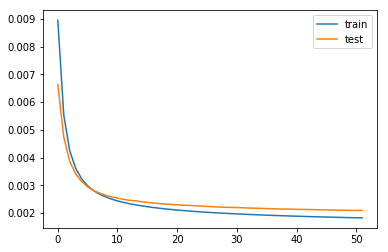

In [32]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

In [33]:
val_proba = model.predict_proba(X_test, batch_size=1024,verbose=1)
test_proba = model.predict_proba(X_go[sp2:], batch_size=1024,verbose=1)

246955/246955 [==============================] - 9s 36us/step


In [34]:
val_proba = pd.DataFrame(val_proba)
test_proba = pd.DataFrame(test_proba)

In [35]:
%%time
val_proba.to_csv('../ensemb3/val_lstm_char_unproc.csv', index = False, header = False)
test_proba.to_csv('../ensemb3/test_lstm_char_unproc.csv', index = False, header = False)

CPU times: user 11min 24s, sys: 30.4 s, total: 11min 55s
Wall time: 12min 5s
